In [1]:
import zipfile
import pandas as pd
import numpy as np
from PIL import Image
import io
# List of paths to your zip files 
# The four zip files should be:
# 1. inpainting.zip
# 2. insight.zip
# 3. text2img.zip
# 4. wiki.zip (contains real images)

#Make sure you do not commit the data to the repository
#Also make sure to not upload your paths to the repository


zip_paths = [
    '../mle_group_6_data/inpainting.zip',
    '../mle_group_6_data/insight.zip',
    '../mle_group_6_data/text2img.zip',
    '../mle_group_6_data/wiki.zip'
]




# Function to add image data to a DataFrame from multiple zip files
def create_image_dataframe(zip_paths, base_num_images_per_zip=1000):
    # List to store image data
    data = []

    # Process each zip file
    for zip_path in zip_paths:
        print(f"Processing zip file: {zip_path}")  # Print current zip file being processed

        # Determine number of images to process based on zip file name
        if 'wiki.zip' in zip_path:
            num_images_per_zip = base_num_images_per_zip * 3
        else:
            num_images_per_zip = base_num_images_per_zip

        with zipfile.ZipFile(zip_path, 'r') as z:
            image_count = 0  # Initialize image counter for the current zip file

            # Iterate over each item in the zip
            for file in sorted(z.namelist()):
                if file.endswith(('.png', '.jpg', '.jpeg')) and '/' in file:
                    # Read the image
                    image_data = z.read(file)
                    image = Image.open(io.BytesIO(image_data))

                    # Convert image to grayscale and resize
                    image = image.convert('RGB').resize((128, 128), Image.LANCZOS)
                    img_array = np.array(image)

                    # Determine if the image is a deepfake or not based on the zip file
                    is_deep_fake = not zip_path.endswith('wiki.zip')

                    # Append image information to the list
                    data.append({
                        'Zip Folder': zip_path,
                        'Image Path': file,
                        'Is DeepFake': is_deep_fake,
                        'Image Data': img_array.flatten()  # Flatten the array
                    })

                    image_count += 1
                    if image_count >= num_images_per_zip:
                        break  # Stop processing if the image limit is reached
                else:
                    print(file)

    # Convert list to DataFrame
    df = pd.DataFrame(data)
    return df

# Call the function and store the DataFrame
df_images = create_image_dataframe(zip_paths)

Processing zip file: ../mle_group_6_data/inpainting.zip
inpainting/
inpainting/00/
inpainting/01/
inpainting/02/
inpainting/03/
Processing zip file: ../mle_group_6_data/insight.zip
insight/
insight/00/
insight/01/
insight/02/
insight/03/
Processing zip file: ../mle_group_6_data/text2img.zip
text2img/
text2img/00/
text2img/01/
text2img/02/
text2img/03/
Processing zip file: ../mle_group_6_data/wiki.zip
wiki/
wiki/00/
wiki/01/
wiki/02/
wiki/03/
wiki/04/
wiki/05/
wiki/06/
wiki/07/
wiki/08/
wiki/09/
wiki/10/


In [3]:
image_counts = df_images['Zip Folder'].value_counts()
dataset_size = 0
for count in image_counts:
    dataset_size = dataset_size + count
print (dataset_size)
print("\nNumber of images from each zip folder:")
print(image_counts)

6000

Number of images from each zip folder:
Zip Folder
../mle_group_6_data/wiki.zip          3000
../mle_group_6_data/inpainting.zip    1000
../mle_group_6_data/insight.zip       1000
../mle_group_6_data/text2img.zip      1000
Name: count, dtype: int64


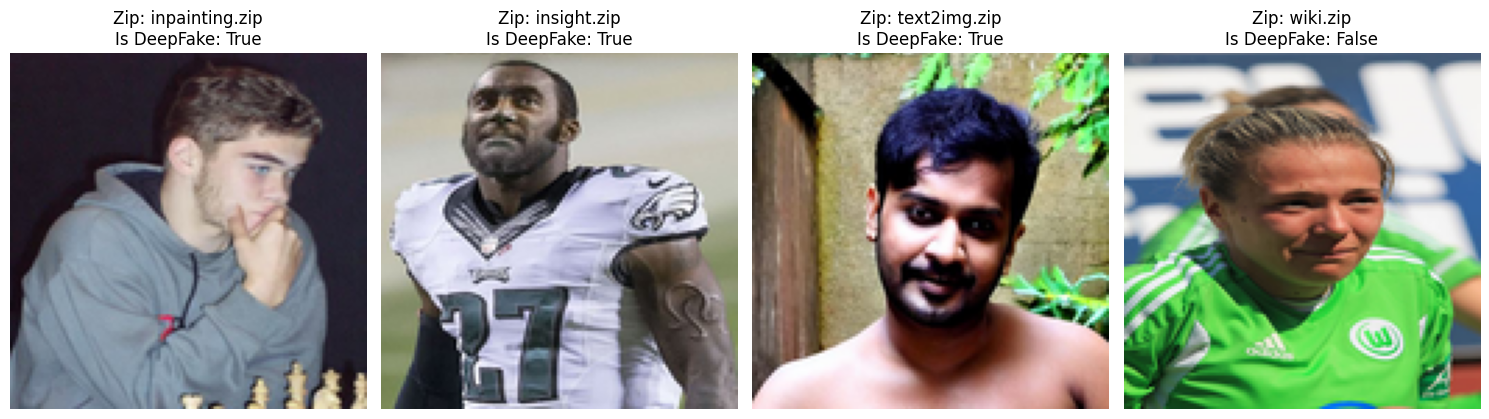

In [4]:
import matplotlib.pyplot as plt
import random

def display_random_images_from_each_zip(df_images):
    # Find unique zip folders
    unique_zip_folders = df_images['Zip Folder'].unique()

    fig, axes = plt.subplots(1, len(unique_zip_folders), figsize=(15, 5))

    # Loop through each unique zip folder
    for i, zip_folder in enumerate(unique_zip_folders):
        # Filter the DataFrame for images only from the current zip folder
        folder_images = df_images[df_images['Zip Folder'] == zip_folder]
        
        # Select a random image from this folder
        random_index = random.randint(0, len(folder_images) - 1)
        image_row = folder_images.iloc[random_index]
        image_data = image_row['Image Data'].reshape(128, 128, 3)  # Reshape the flattened array back to 128x128
        is_deep_fake = image_row['Is DeepFake']  # Retrieve the 'Is DeepFake' status correctly from the row

        # Plot the image
        ax = axes[i] if len(unique_zip_folders) > 1 else axes
        ax.imshow(image_data, cmap='gray')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Zip: {zip_folder.split('/')[-1]}\nIs DeepFake: {is_deep_fake}")


    plt.tight_layout()
    plt.show()

# Call the function to display the images
display_random_images_from_each_zip(df_images)


In [5]:
import numpy as np
import tensorflow as tf

def prepare_data_for_cnn(df_images):
    # Convert flattened images to 2D shape and expand dimensions to include the channel
    # This lambda function assumes each row in 'Image Data' is a flattened image of 128x128 pixels
    images = np.stack(df_images['Image Data'].apply(lambda x: np.reshape(x, (128, 128, 3))))

    # Normalize the images to have values between 0 and 1
    #images = images.astype('float32') / 255.0

    # Extract labels and convert them to integer format
    labels = df_images['Is DeepFake'].values.astype('int')

    return images, labels

# Assuming df_images is your DataFrame containing the required image data
images, labels = prepare_data_for_cnn(df_images)

# Create a TensorFlow dataset from the numpy arrays
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
train_size = int(0.5 * dataset_size)
test_size = int(0.25 * dataset_size)
val_size = int(0.25 * dataset_size)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print(train_dataset.cardinality().numpy())
print(test_dataset.cardinality().numpy())
print(val_dataset.cardinality().numpy())


train_dataset = dataset.shuffle(buffer_size=1000).batch(32)  # Shuffle and batch the dataset

# Take one batch from the dataset and print shapes
for images_batch, labels_batch in dataset.take(1):
    print("Images shape:", images_batch.shape)  # Expected shape: (batch_size, 128, 128, 1)
    print("Labels shape:", labels_batch.shape)  # Expected shape: (batch_size,)


2024-04-25 12:43:01.856863: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 12:43:03.055168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-25 12:43:05.870621: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


3000
1500
1500
Images shape: (128, 128, 3)
Labels shape: ()


2024-04-25 12:43:05.984170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 12:43:05.984256: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 12:43:05.988276: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 12:43:05.988346: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 12:43:05.988385: I external/local_xla/xla/stream_executor

In [ ]:
from tensorflow.keras import layers, models
import tensorflow.keras as keras
#dataset = tf.data.Dataset.from_tensor_slices((images, labels))
#dataset = dataset.shuffle(buffer_size=1000).batch(32)

def build_and_train_model(dataset):
    model = models.Sequential([
        layers.Conv2D(128, (3, 3), padding='same', strides=(2,2), activation='relu', input_shape=(128, 128, 3)),
        layers.Dropout(.3),
        layers.Conv2D(256, (3, 3), padding='same', strides=(2,2), activation='relu'),
        layers.Dropout(.3),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(dataset, epochs=50)
    return model, history

model, history = build_and_train_model(train_dataset)

Epoch 1/50


/home/retalak/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-25 12:52:38.298284: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng1{k2=6,k3=0} for conv (f32[256,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,65,65]{3,2,1,0}, f32[32,256,32,32]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-04-25 12:52:38.410044: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.111917087s
Trying algorithm en

188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 145ms/step - accuracy: 0.9007 - loss: 37.3039
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.7871 - loss: 0.8704
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.7952 - loss: 0.9259
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.8394 - loss: 0.7313
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.8094 - loss: 0.5924
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.7949 - loss: 0.6787
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.8254 - loss: 0.5808
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.8244 - loss: 0.5240
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.8444 - loss: 0.4859
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.8168 - loss: 0.7641
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.8455 - loss: 0.8025
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━